In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns
import bokeh
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure
output_notebook()
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, Range1d, PanTool, WheelZoomTool, BoxSelectTool, HoverTool, CustomJS
)
from bokeh.tile_providers import STAMEN_TONER

# Let's first do some coloring magic that converts the color palet into map numbers (it's okey not to understand)
from bokeh.palettes import RdYlBu11 as palette
from bokeh.models import LogColorMapper

# Create the color mapper
color_mapper = LogColorMapper(palette=palette)

# https://developers.google.com/maps/documentation/javascript/get-api-key
from config import GOOGLE_API_KEY

Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

In [2]:
def df2gdf(df, lat, lon):
    geometry = [Point(xy) for xy in zip(df[lon], df[lat])]
    df = df.drop([lon, lat], axis=1)
    crs = {'init': 'epsg:4326'}
    gdf = GeoDataFrame(df, crs=crs, geometry=geometry)
    return gdf

## Ship types                                                                                                                                                                                                                                                                              
- 0 UnspecifiedShips                                                     
- 1 NavigationAids                                                                                                                                                                                                                                              
- 2 Fishing                                                                                                                                                                                                                                                          
- 3 Tugs&SpecialCraft                                                                                                                                                                                                                                      
- 4 HighSpeedCraft                                                                                                                                                                                                                                              
- 6 PassengerVessels                                                                                                                                                                                                                                               
- 7 CargoVessels                                                                                                                                                                                                                                                   
- 8 Tankers                                                                                                                                                                                                                                                     
- 9 PleasureCraft

In [39]:
all_ships3 = pd.DataFrame(data=np.load("all_ships.zoom=3.npz")['all_ships']) 
all_ships4 = pd.DataFrame(data=np.load("all_ships.zoom=4.npz")['all_ships']) 
all_ships5 = pd.DataFrame(data=np.load("all_ships.zoom=5.npz")['all_ships']) 

all_ships = all_ships3
all_ships = all_ships.append(all_ships4, ignore_index=True)
all_ships = all_ships.append(all_ships5, ignore_index=True)

all_ships.drop(columns=['index'], inplace=True)

In [46]:
mask_types = [7, 8, 2]
all_ships = all_ships.loc[all_ships.SHIPTYPE.isin(mask_types)]
geo_ships = df2gdf(all_ships, 'LAT', 'LON')

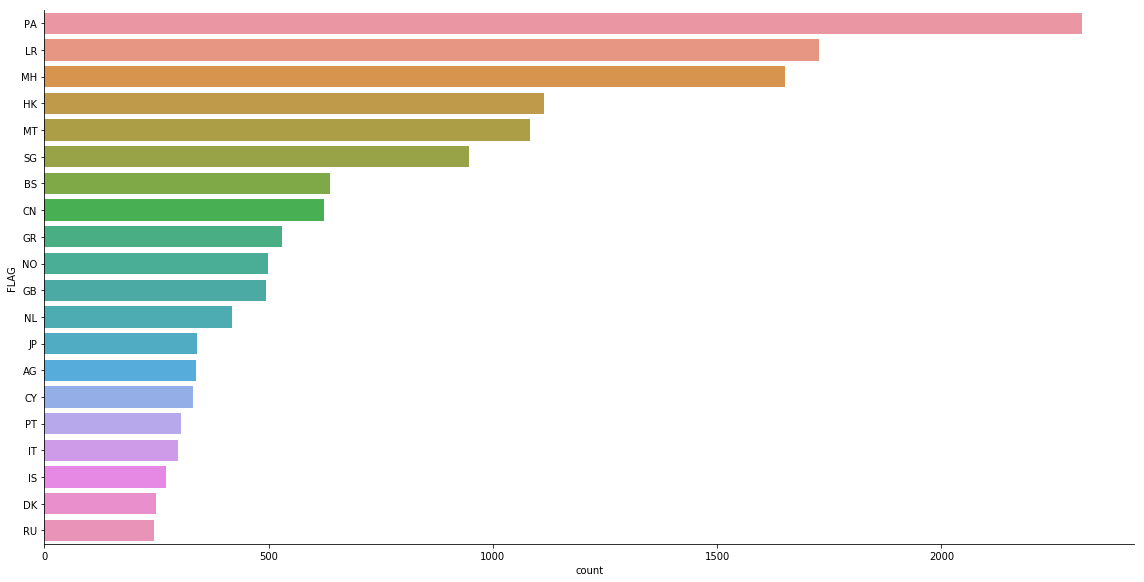

In [47]:
sns.factorplot(y='FLAG', data=all_ships, kind='count', 
               order=all_ships.FLAG.value_counts().index.values[:20], 
               size=8, aspect=2)

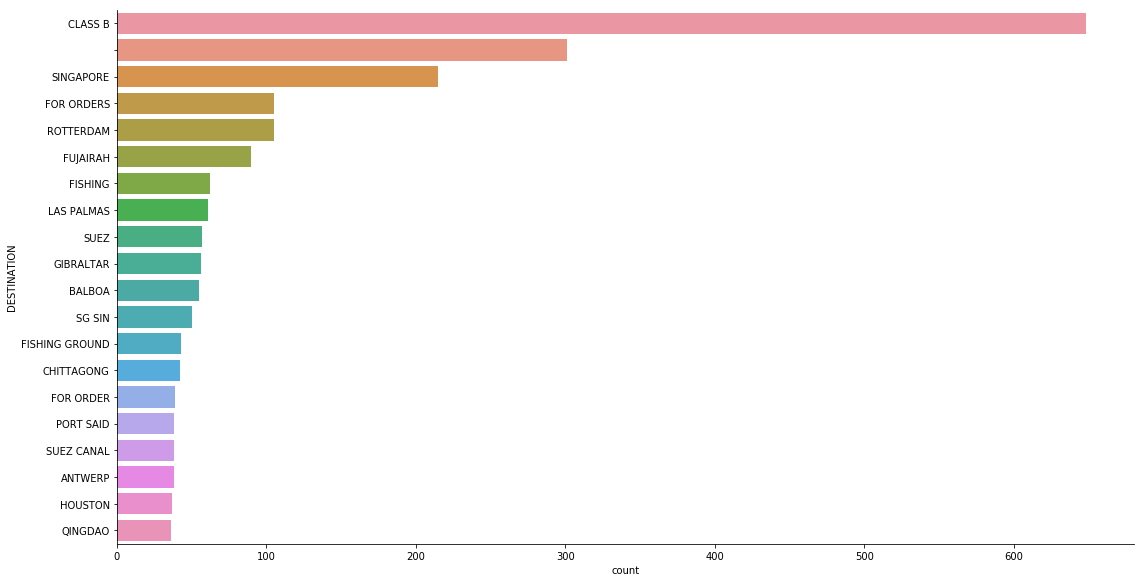

In [48]:
sns.factorplot(y='DESTINATION', data=all_ships, kind='count', 
               order=all_ships.DESTINATION.value_counts().index.values[:20], 
               size=8, aspect=2)

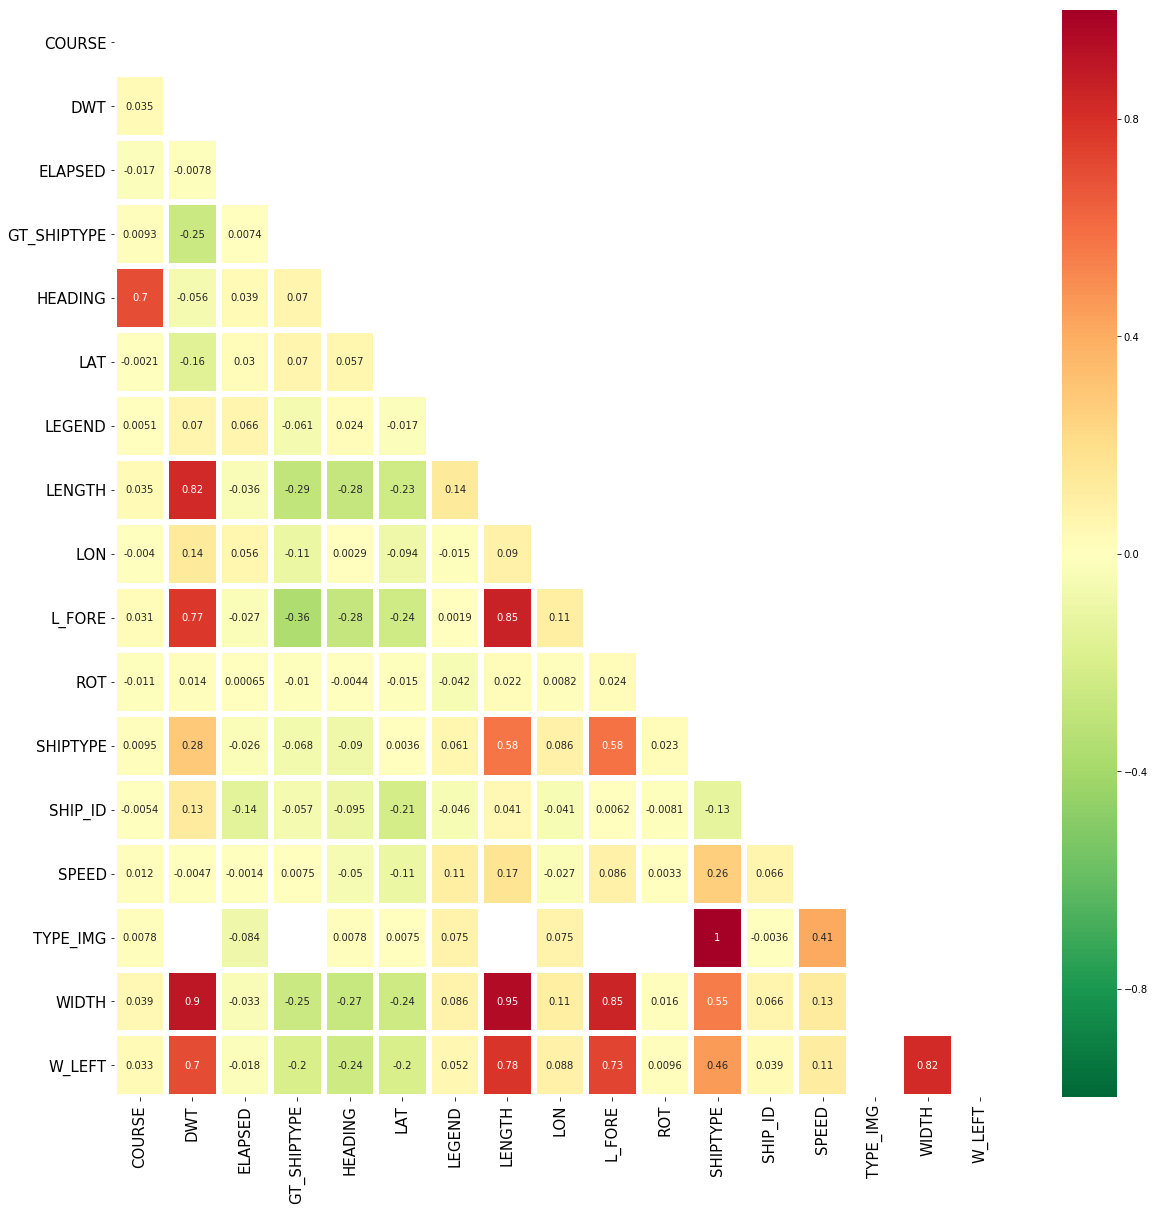

In [67]:
f, ax = plt.subplots(figsize=(20, 20))
corr = all_ships.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,
            cmap='RdYlGn_r', vmax=1.0, vmin=-1.0,
            mask=mask, annot=True, linewidths=5, 
            ax=ax)
_ = plt.setp(ax.get_xticklabels(), rotation='vertical', fontsize=15)
_ = plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=15)

/home/saghar/.virtualenvs/02ML/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


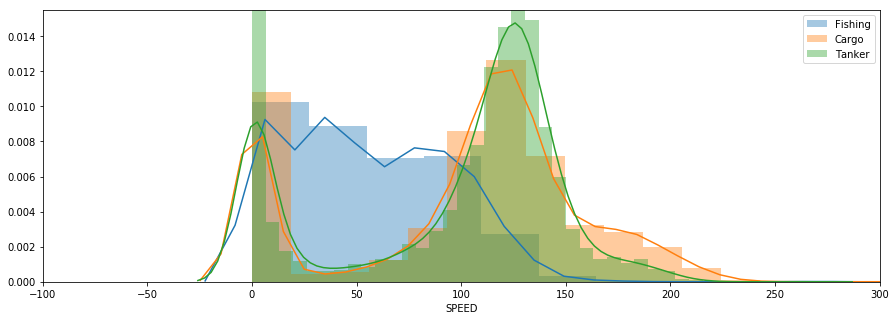

In [52]:
f, ax = plt.subplots(figsize=(15,5))
sns.distplot(all_ships.loc[all_ships.SHIPTYPE==2, 'SPEED'], hist=True, label='Fishing', ax=ax)
sns.distplot(all_ships.loc[all_ships.SHIPTYPE==7, 'SPEED'], hist=True, label='Cargo', ax=ax)
sns.distplot(all_ships.loc[all_ships.SHIPTYPE==8, 'SPEED'], hist=True, label='Tanker', ax=ax)
ax.set_xlim(-100,300)
plt.legend()

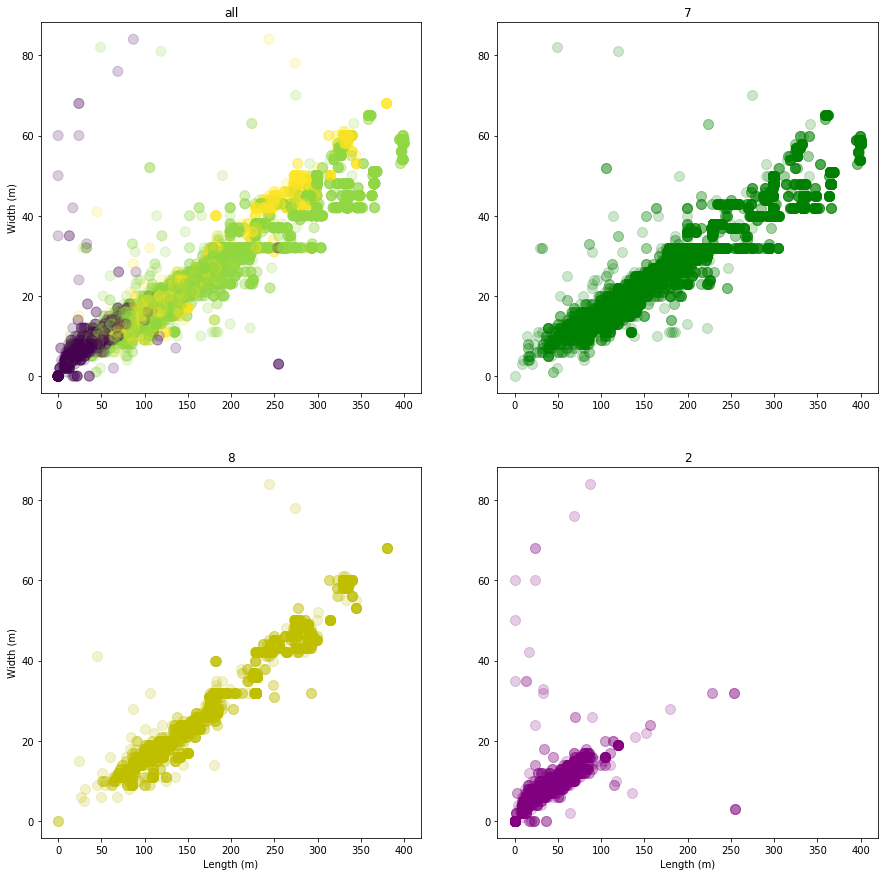

In [71]:
f, ax = plt.subplots(2,2,figsize=(15,15))
colors = ['k', 'g', 'y', 'purple']
ax = ax.flatten()
ax[0].scatter(all_ships.LENGTH, all_ships.WIDTH, c=all_ships.SHIPTYPE, s=100, alpha=0.2)
ax[0].set_title('all')
for (i,t) in zip(range(1,4), mask_types):
    ax[i].scatter(all_ships.loc[all_ships.SHIPTYPE==t, 'LENGTH'], 
                  all_ships.loc[all_ships.SHIPTYPE==t, 'WIDTH'], 
                  facecolor=colors[i], s=100, alpha=0.2)
    ax[i].set_title(t)
    ax[i].set_xlim(ax[0].get_xlim())
    ax[i].set_ylim(ax[0].get_ylim())
for i in [0,2]:
    ax[i].set_ylabel('Width (m)')
for i in [2,3]:
    ax[i].set_xlabel('Length (m)')

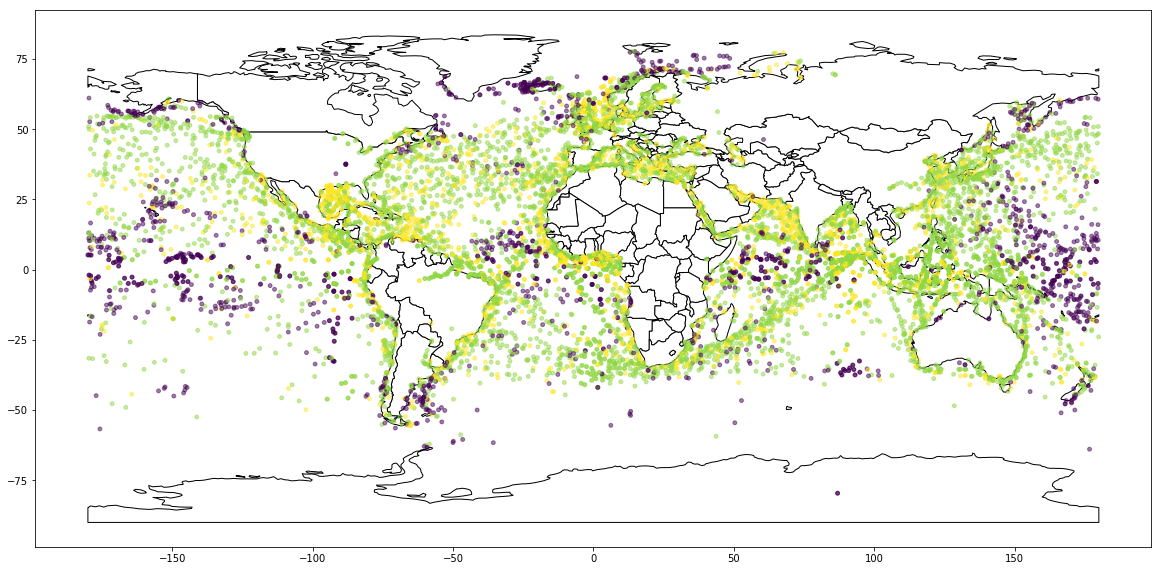

In [22]:
base = world.plot(color='white', edgecolor='black', figsize=(20,20))
geo_ships.plot(ax=base, marker='o', column='SHIPTYPE', markersize=15, legend=False, alpha=0.5)
plt.show()

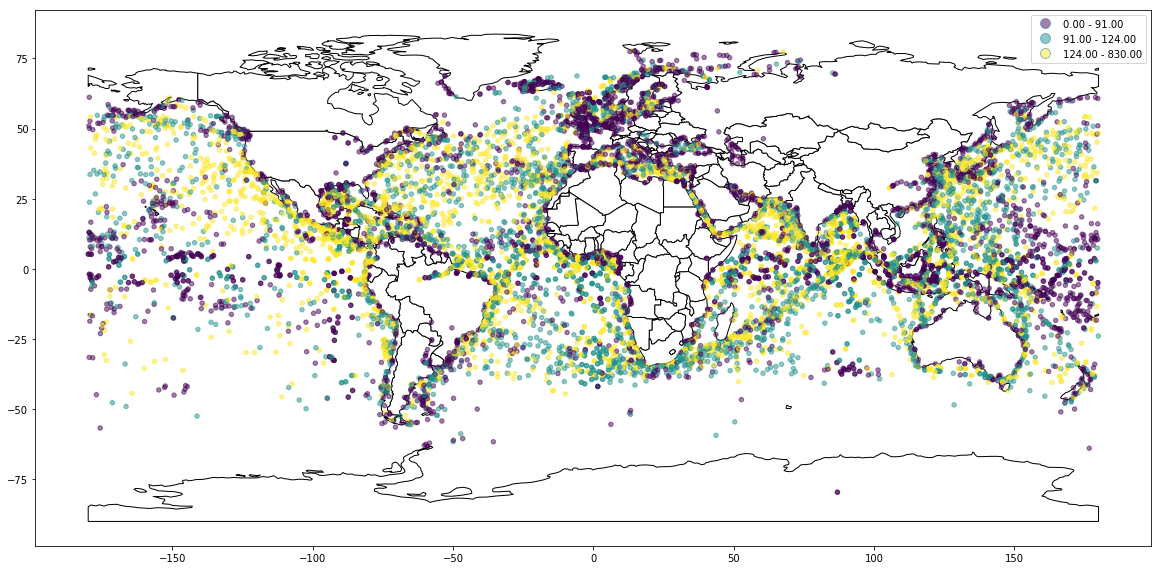

In [23]:
base = world.plot(color='white', edgecolor='black', figsize=(20,20))
geo_ships.plot(ax=base, marker='o', column='SPEED', 
               scheme='Quantiles', k=3,
               markersize=20, legend=True, alpha=0.5)
plt.show()

In [24]:
def getPointCoords(row, geom, coord_type):
    """Calculates coordinates ('x' or 'y') of a Point geometry"""
    if coord_type == 'x':
        return row[geom].x
    elif coord_type == 'y':
        return row[geom].y

In [25]:
geo_ships['x'] = geo_ships.apply(getPointCoords, geom='geometry', coord_type='x', axis=1)
geo_ships['y'] = geo_ships.apply(getPointCoords, geom='geometry', coord_type='y', axis=1)
ships = geo_ships.drop('geometry', axis=1).copy()
src_fishing = ColumnDataSource(ships.loc[ships.SHIPTYPE==2])
src_cargo = ColumnDataSource(ships.loc[ships.SHIPTYPE==7])
src_tanker = ColumnDataSource(ships.loc[ships.SHIPTYPE==8])
my_hover = HoverTool()
my_hover.tooltips = [('Name', '@SHIPNAME'), ('Type', '@TYPE_NAME')]

In [26]:
from bokeh.io import output_file, show
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, Range1d, PanTool, WheelZoomTool, BoxSelectTool
)

map_options = GMapOptions(lat=0., lng=0., map_type="satellite", zoom=1)

plot = GMapPlot(x_range=Range1d(), y_range=Range1d(), map_options=map_options)
#plot.title.text = "Ships"

# For GMaps to function, Google requires you obtain and enable an API key:
#
#     https://developers.google.com/maps/documentation/javascript/get-api-key
#
# Replace the value below with your personal API key:
plot.api_key = "GOOGLE_API_KEY"

fishings = Circle(x="x", y="y", size=5, fill_color='purple', fill_alpha=0.8, line_color=None)
cargos = Circle(x="x", y="y", size=5, fill_color='green',  fill_alpha=0.8, line_color=None)
tankers = Circle(x="x", y="y", size=5, fill_color='yellow', fill_alpha=0.8, line_color=None)

plot.add_glyph(src_cargo, cargos)
plot.add_glyph(src_tanker, tankers)
plot.add_glyph(src_fishing, fishings)

plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool(), my_hover)
show(plot)

'/home/saghar/IG/projects/02ML'